In [65]:
# Dependencies and Setup
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import  statsmodels.api as sm
from statsmodels.formula.api import ols
# File to load
Melbourne_refined_listings_cleaned = Path ("Outputs/Melbourne_refined_listings_cleaned.csv")

# Read Melbourne_refined_listings_cleaned data
airbnb_data = pd.read_csv(Melbourne_refined_listings_cleaned)
airbnb_data.head()


,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,572431386115618941,446636199,2022-02-24,"St Kilda, Australia",within an hour,95%,99%,f,t,t,...,4.0,4.6,4.43,4.37,3.97,8,0,4,4,1.21
1,727686708237430703,382295537,2020-12-30,"Melbourne, Australia",within a few hours,89%,57%,f,t,t,...,4.2,4.2,4.20,4.20,4.20,3,0,3,0,0.81
2,1051913801382467131,22860147,2014-10-22,"Melbourne, Australia",within an hour,100%,99%,f,t,t,...,5.0,5.0,5.00,4.50,4.00,105,105,0,0,0.98
3,1106234039745058155,16365362,2014-06-04,"Melbourne, Australia",within an hour,100%,100%,f,t,t,...,5.0,5.0,5.00,5.00,5.00,1,0,1,0,1.00
4,1053974246558615906,551937839,2023-12-21,"Point Cook, Australia",within an hour,97%,94%,f,t,t,...,4.0,3.5,4.00,4.00,5.00,7,7,0,0,2.00


In [81]:
#Convert host_since to datetime format if it's not already

airbnb_data['host_since'] = pd.to_datetime(airbnb_data['host_since'])


In [82]:
# Calculate Host experience in years
airbnb_data['host_experience_years'] = (datetime.now() - airbnb_data['host_since']).dt.days / 365

In [83]:
# Change "price` to numeric by stripping the '$' and converting to float
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)


In [85]:
# Aggregate data by host
host_data = airbnb_data.groupby('host_id').agg({
    'host_experience_years': 'max',  # Use max for years of experience
    'id': 'count',                   # Count number of listings
    'price': 'mean',                 # Mean price
    'number_of_reviews': 'sum',      # Total reviews
    'review_scores_rating': 'mean'   # Average rating
}).rename(columns={
    'id': 'num_listings',
    'number_of_reviews': 'total_reviews',
    'review_scores_rating': 'avg_rating'
}).reset_index()  # Reset index for cleanliness
host_data

,host_id,host_experience_years,num_listings,price,total_reviews,avg_rating
0,9082,15.350685,2,105.0,28,4.89
1,15565,15.191781,1,300.0,1,4.00
2,18785,15.128767,1,138.0,2,5.00
3,20588,15.090411,1,132.0,54,4.98
4,21345,15.076712,1,115.0,31,4.77
...,...,...,...,...,...,...
5130,561797490,0.397260,1,368.0,3,5.00
5131,561798630,0.397260,1,157.0,5,5.00
5132,562103428,0.394521,2,75.0,2,5.00
5133,562487587,0.386301,1,312.0,1,1.00


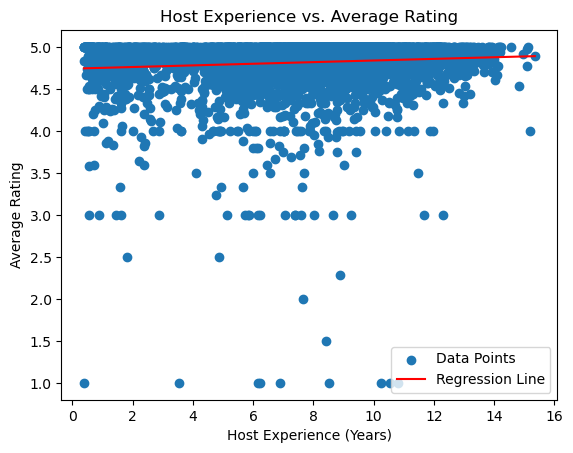

In [86]:
#Scatter plot: Host experience vs. Average rating

# Define Variables
X = host_data['host_experience_years']
Y = host_data ['avg_rating']

#Calculate Regression line
coefficients = np.polyfit(X,Y, 1)
poly = np.poly1d(coefficients)
regression_line = poly (X)

#Scatter Plot
plt.scatter(X, Y, label='Data Points')

#Regression Line
plt.plot (X, regression_line, color = 'red', label = 'Regression Line')

#Add labels and tittle
plt.xlabel ('Host Experience (Years)')
plt.ylabel ('Average Rating')
plt.title ('Host Experience vs. Average Rating')
plt.legend()

# Save the plot to a file
output_path = 'plots/Scatter_showing_experience_vs_Ratings.png'
plt.savefig(output_path)
#Show plot
plt.show()

The above presentation show that there is a slight positive correlation between average rating and host experience. 

In [45]:
# Hypothesis Testing and statistical analysis
# Correlation analysis 
correlation, p_value = pearsonr(host_data['host_experience_years'], host_data['avg_rating']) 
print(f'Correlation: {correlation}, P-value: {p_value}')

Correlation: 0.09666074573748677, P-value: 3.888496808457316e-12


In [48]:
# Linear regression
X = sm.add_constant(host_data['host_experience_years']) 
y = host_data['avg_rating'] 
model = sm.OLS(y, X).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     48.41
Date:                Sun, 07 Jul 2024   Prob (F-statistic):           3.89e-12
Time:                        15:09:08   Log-Likelihood:                -1126.8
No. Observations:                5135   AIC:                             2258.
Df Residuals:                    5133   BIC:                             2271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.74

The above presentation show that there is a weak positive correlation between average rating and host experience. The P Value of 3.888496808457316e-12 is exceedingly small, much smaller than 0.05, indicating that the correlation is statistically significant. Therefore, while there is some statistically significant positive correlation between average rating and host experience, the actual influence that host experience has on average rating is almost negligible.In practical terms, even though we have found a statistically significant correlation, the weak strength suggests that host experience may not have a strong impact on average ratings. Other factors might play a more crucial role in determining average ratings and should be explored.

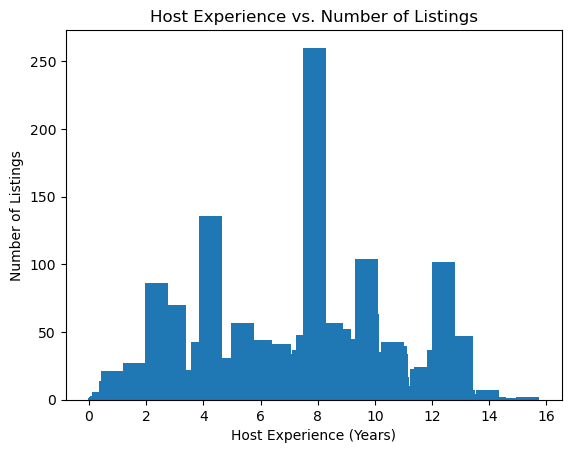

In [71]:
# Bar Chart showing number of listings per avarage rating
plt.bar(host_data['host_experience_years'], host_data['num_listings'])
plt.title('Host Experience vs. Number of Listings')
plt.xlabel('Host Experience (Years)')
plt.ylabel('Number of Listings')

# Save the plot to a file
output_path = 'plots/experience_vs_listings.png'
plt.savefig(output_path)

# Show the plot
plt.show()

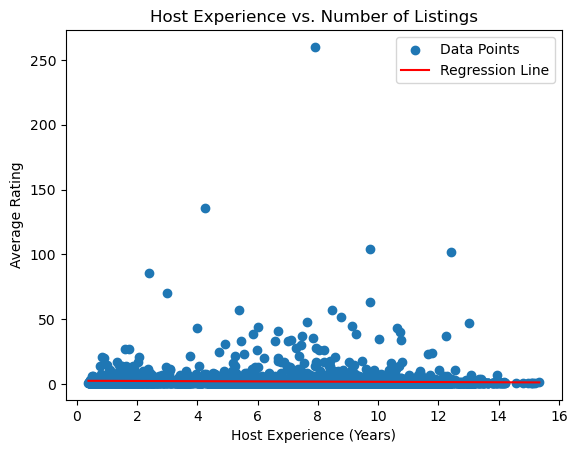

In [76]:
#Scatter plot: Host experience vs. Number of Listings

# Define Variables
X = host_data['host_experience_years']
Y = host_data ['num_listings']

#Calculate Regression line
coefficients = np.polyfit(X,Y, 1)
poly = np.poly1d(coefficients)
regression_line = poly (X)

#Scatter Plot
plt.scatter(X, Y, label='Data Points')

#Regression Line
plt.plot (X, regression_line, color = 'red', label = 'Regression Line')

#Add labels and tittle
plt.xlabel ('Host Experience (Years)')
plt.ylabel ('Average Rating')
plt.title ('Host Experience vs. Number of Listings')
plt.legend()

# Save the plot to a file
output_path = 'plots/Scatter_showing_experience_vs_listings.png'
plt.savefig(output_path)
#Show plot
plt.show()

The above Scatter shows that there is no relationship between host experience vs. number of listings

In [ ]:
#Calculate correlation between 'price' and 'number_of_reviews'
# Convert 'price' to numeric by stripping the '$' and converting to float
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)
correlation = airbnb_data['price'].corr(airbnb_data['number_of_reviews'])

# Print correlation result
print(f"Correlation between price and number of reviews: {correlation:.2f}")

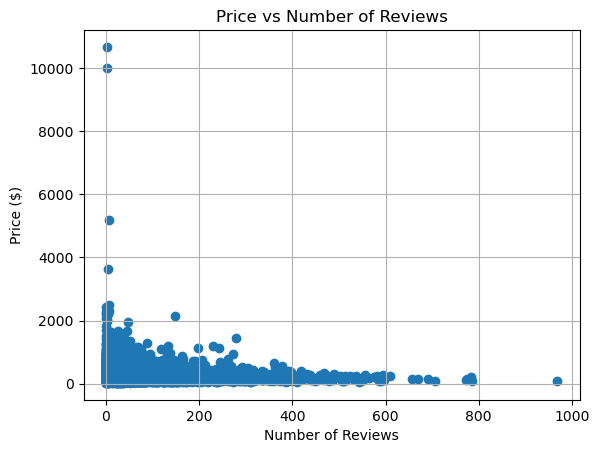

In [78]:
# Plot the relationship
import matplotlib.pyplot as plt

plt.scatter(airbnb_data['number_of_reviews'], airbnb_data['price'])
plt.title('Price vs Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Price ($)')
plt.grid(True)

# Save the plot to a file
output_path = 'plots/Scatter_Price_vs_Reviews.png'
plt.savefig(output_path)
plt.show()

The above scatter plost shows that there is little to no linear relationship between the number of reviews and Airbnn price. This is alos supported by the correlation calculation of -0.06.

In [87]:
#Calculate correlation between 'price' and 'host_experience'
# Convert 'price' to numeric by stripping the '$' and converting to float
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)
correlation = airbnb_data['price'].corr(airbnb_data['host_experience_years'])

# Print correlation result
print(f"Correlation between price and host experince years: {correlation:.2f}")

Correlation between price and host experince years: 0.03


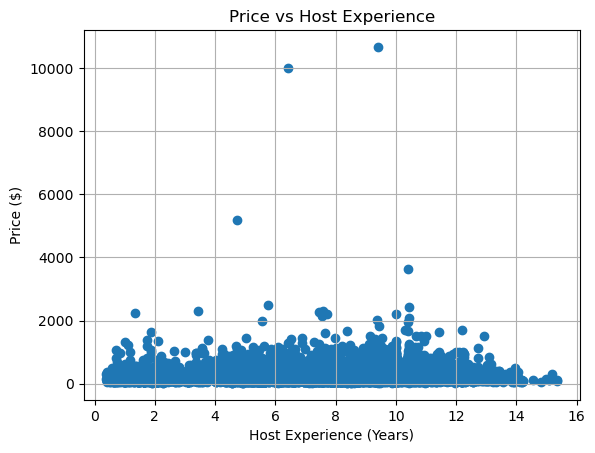

In [88]:
# Plot the relationship
import matplotlib.pyplot as plt

plt.scatter(airbnb_data['host_experience_years'], airbnb_data['price'])
plt.title('Price vs Host Experience')
plt.xlabel('Host Experience (Years)')
plt.ylabel('Price ($)')
plt.grid(True)

# Save the plot to a file
output_path = 'plots/Scatter_Price_vs_Host_experience.png'
plt.savefig(output_path)
plt.show()

The above scatter plost shows that there is little positive or no linear relationship between the host experinece and Airbnn price. This is alos supported by the correlation calculation of 0.03